Deny Andriana

Membuat Model Machine Learning dengan Data Time Series

Dataset: Londo Weather Data ------Link:!kaggle datasets download -d emmanuelfwerr/london-weather-data

In [1]:
# install kaggle
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enkei0107","key":"86678fa772f067d6e189be9ee711580f"}'}

In [3]:
#Library
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

import matplotlib.pyplot as plt


In [4]:
# buat directory 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
#download dataset dari kaggle
!kaggle datasets download -d emmanuelfwerr/london-weather-data

100% 226k/226k [00:00<00:00, 564kB/s]
100% 226k/226k [00:00<00:00, 564kB/s]


In [6]:
#extract dataset
!mkdir weather-dataset
!unzip london-weather-data.zip -d weather-dataset
!ls weather-dataset

Archive:  london-weather-data.zip
  inflating: weather-dataset/london_weather.csv  
london_weather.csv


In [7]:
#load dataset dari file dataset yang telah di extract
import pandas as pd
df = pd.read_csv('weather-dataset/london_weather.csv')
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

In [22]:
#jumlah sample data
df.shape

(15341, 10)

In [16]:
#cek data apakah ada yg kosong
df.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [27]:
#hapus baris yg memiliki nilai null 
df.dropna(subset=['cloud_cover'],inplace=True)
df.dropna(subset=['global_radiation'],inplace=True)
df.dropna(subset=['snow_depth'],inplace=True)
df.dropna(subset=['mean_temp'],inplace=True)
df.dropna(subset=['max_temp'],inplace=True)
df.dropna(subset=['min_temp'],inplace=True)
df.dropna(subset=['precipitation'],inplace=True)
df.dropna(subset=['pressure'],inplace=True)
df.isnull().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [28]:
df.shape

(13843, 10)

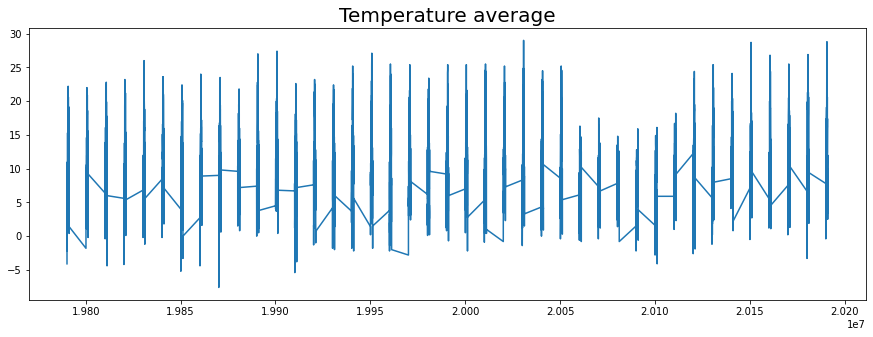

In [29]:
#menampilkan rata rata temperatur
dates = df['date'].values
temp  = df['mean_temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [30]:
#membagi dataset menjadi 2 data train(80%) dan validation (20%)
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [31]:
#total data train dan validation
print('Total data Train : ',len(x_train))
print('Total data Validation : ',len(x_valid))

Total data Train :  11074
Total data Validation :  2769


In [33]:
#mengubah data kita menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [37]:
#model sequential ditambah dengan LSTM
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
validation_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [38]:
#menghitung nilai MAE
Mae = (df['mean_temp'].max() - df['mean_temp'].min()) * 10/100
print(Mae)

3.66


In [41]:
#membuat fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<3.6 and logs.get('val_mae')<3.6):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [42]:
#Penggunaan learning rate 
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = validation_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


56/56 [==============================] - 91s 1s/step - loss: 7.4248 - mae: 7.9139 - val_loss: 6.9744 - val_mae: 7.4612
Epoch 2/100
56/56 [==============================] - 83s 1s/step - loss: 4.9581 - mae: 5.4369 - val_loss: 4.4121 - val_mae: 4.8903
Epoch 3/100
56/56 [==============================] - 84s 1s/step - loss: 3.6953 - mae: 4.1713 - val_loss: 3.7505 - val_mae: 4.2265
Epoch 4/100
56/56 [==============================] - 83s 1s/step - loss: 3.3422 - mae: 3.8160 - val_loss: 3.3493 - val_mae: 3.8194
Epoch 5/100
56/56 [==============================] - ETA: 0s - loss: 2.8599 - mae: 3.3288
MAE dari model < 10% skala data
56/56 [==============================] - 83s 1s/step - loss: 2.8599 - mae: 3.3288 - val_loss: 2.6376 - val_mae: 3.1034


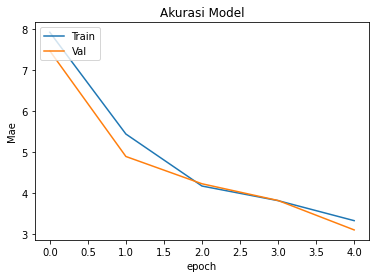

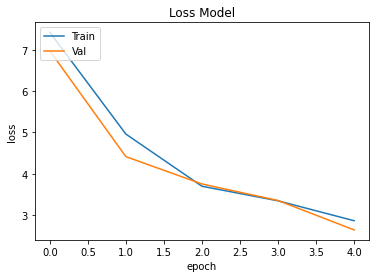

In [44]:
#menampilkan visualisasi plot
# Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()